In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'svg'

## LSTM

In [3]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm


def denormalize(test_y, df, predict_target = "3_day_return"):
    return test_y * (np.max(df[predict_target]) - np.min(df[predict_target])) + np.mean(
        df[predict_target]
    )


def train_(df, ref_day=5, predict_day=1, predict_target = "3_day_return"):
    X_train, Y_train = [], []
    for i in range(df.shape[0] - predict_day - ref_day):
        X_train.append(np.array(df.iloc[i : i + ref_day, df.columns != predict_target]))
        Y_train.append(
            np.array(df.iloc[i + ref_day : i + ref_day + predict_day][predict_target])
        )
    return np.array(X_train), np.array(Y_train)


def get_train_test(X, Y, split_boundary):
    train_x = X[:split_boundary]
    test_x = X[split_boundary:]
    train_y = Y[:split_boundary]
    test_y = Y[split_boundary:]
    return train_x, test_x, train_y, test_y


def get_model(train_x):
    model = Sequential()
    model.add(
        LSTM(
            units=50,
            return_sequences=True,
            input_shape=(train_x.shape[1], train_x.shape[2]),
        )
    )
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

    return model


def train(df, title=None, split_boundary=2110, predict_target = "3_day_return"):

    norm_df = normalize(df)

    # 7 days predict 1 day
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    es = EarlyStopping(monitor="loss", patience=50, verbose=0, mode="min")
    history = model.fit(
        train_x, train_y, epochs=1000, batch_size=128, verbose=0, callbacks=[es]
    )

    fig = make_subplots(rows=2, cols=1)
    fig.add_trace(
        go.Scatter(y=history.history["loss"], name="training loss"), row=1, col=1
    )

    score = model.evaluate(test_x, test_y, verbose=0)
    predict_y = model.predict(test_x)
    #     norm_mse = mean_squared_error(test_y, predict_y)
    test_y_list = denormalize(test_y, df, predict_target).ravel()
    predict_y_list = denormalize(predict_y, df, predict_target).ravel()
    mean = np.mean(np.abs(np.array(predict_y_list) - np.array(test_y_list)))

    fig.add_trace(
        go.Scatter(y=test_y_list, mode="lines", name="actual return"), row=2, col=1
    )
    fig.add_trace(
        go.Scatter(y=predict_y_list, mode="lines", name="predict return"), row=2, col=1
    )
    fig.update_layout(
        title_text="Crops : {}, Loss : {}, Mean: {}".format(title, score[0], mean),
    )
    fig.show()


crops_arr = [
    "香蕉",
    "洋香瓜-網狀紅肉",
    "蓮霧-紅蓮霧",
    "鳳梨-金鑽鳳梨",
    "南瓜-木瓜形",
    "大蒜-蒜瓣",
    "青蔥-日蔥",
    "小白菜-土白菜",
    "芽菜類-黃豆牙",
    "木瓜-網室紅肉",
]


## Predict without feature selection

### 1 day return

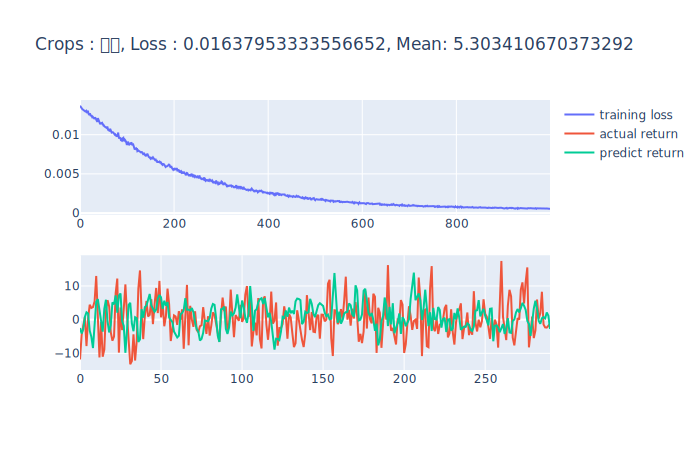

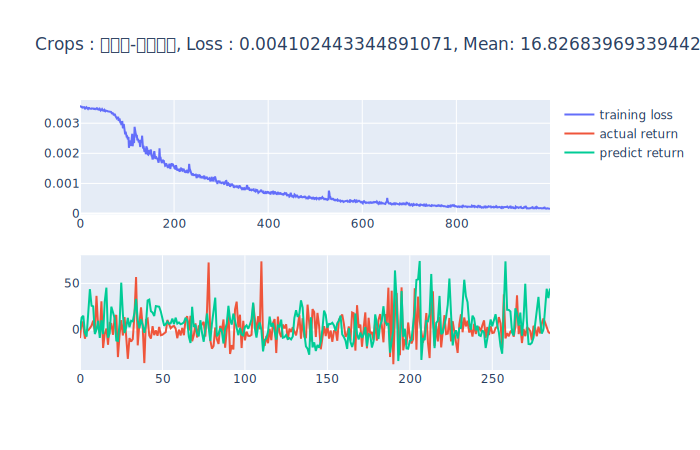

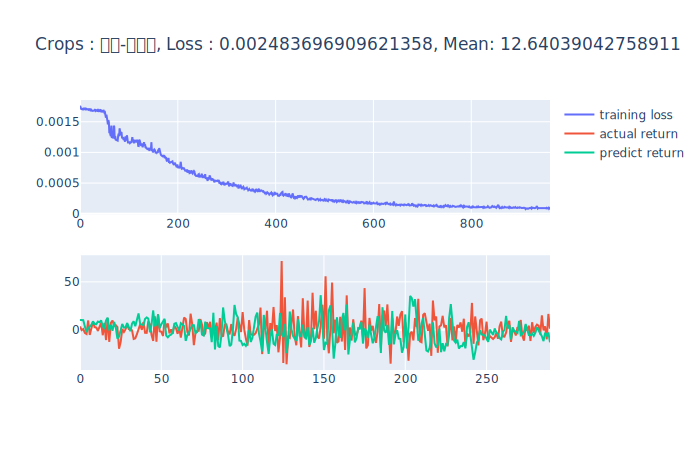

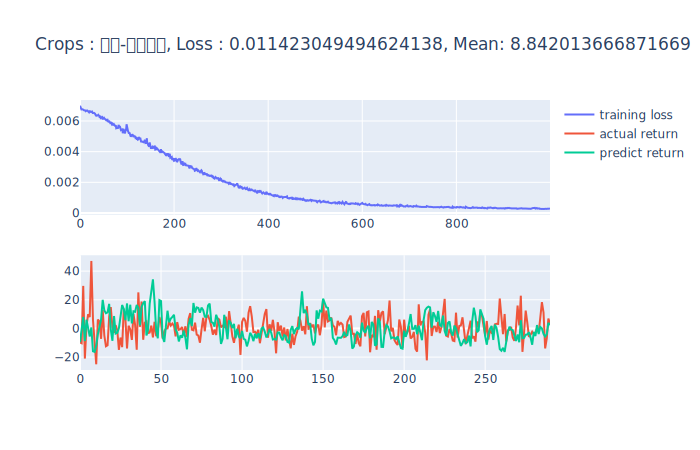

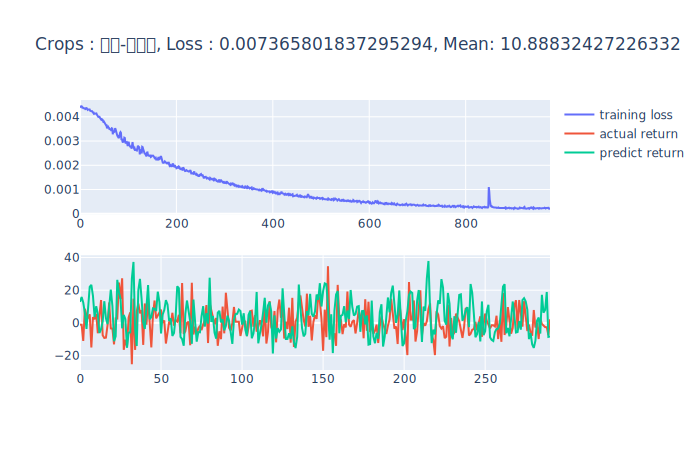

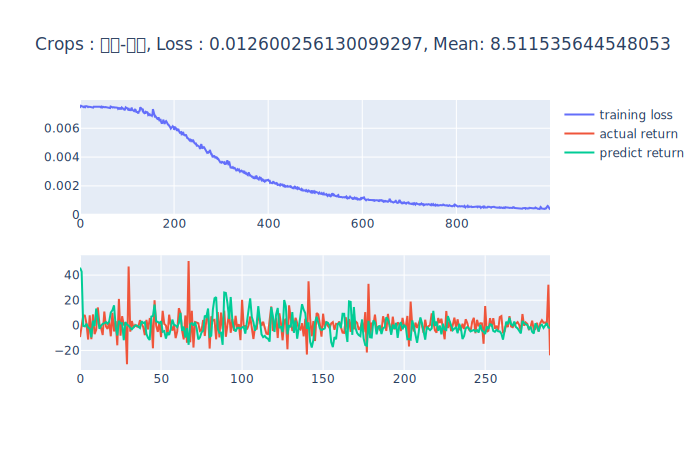

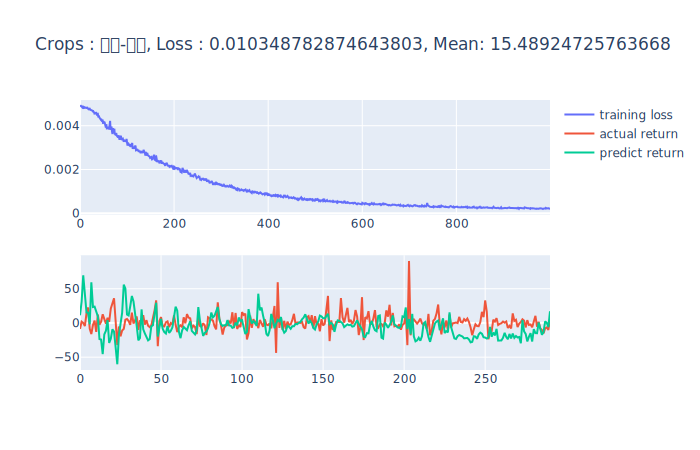

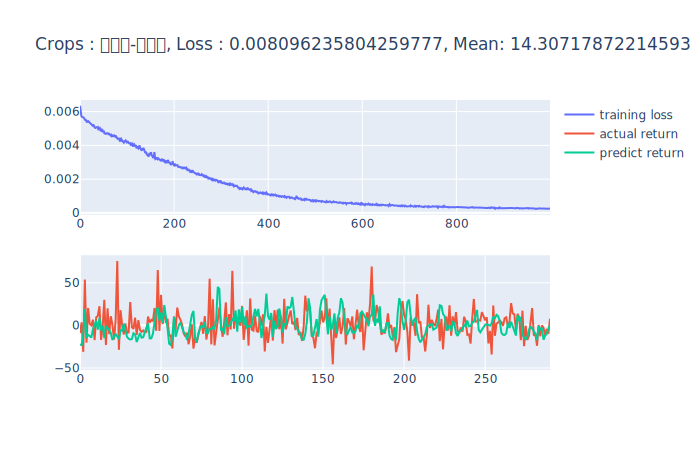

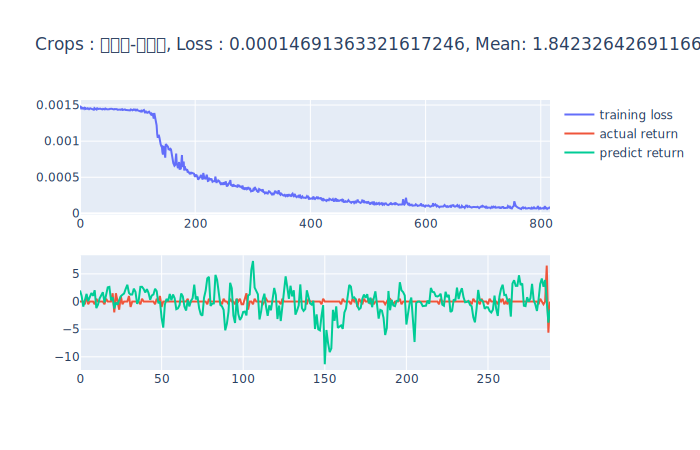

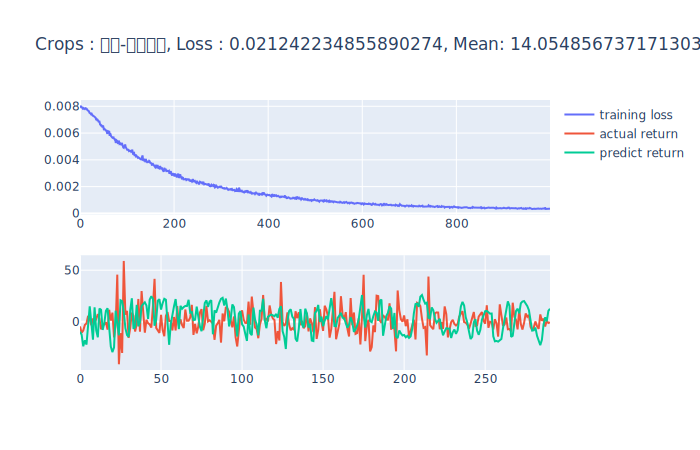

In [3]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    train(
        df.drop(columns=["DateTime", "Year", "Day", "3_day_return", "5_day_return"]),
        crops,
        split_boundary,
        "1_day_return"
    )

### 3 days return

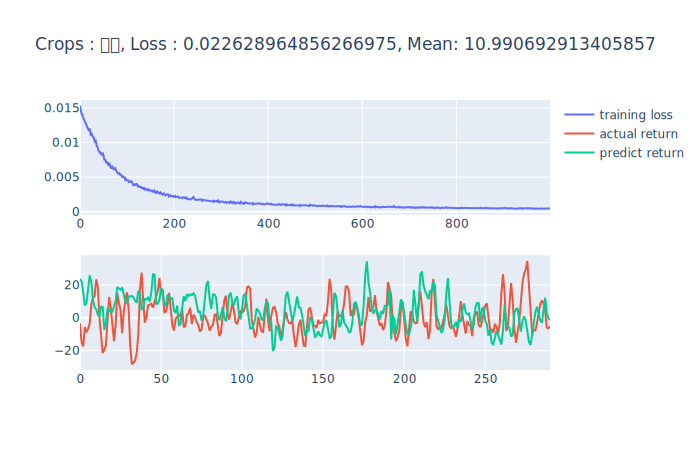

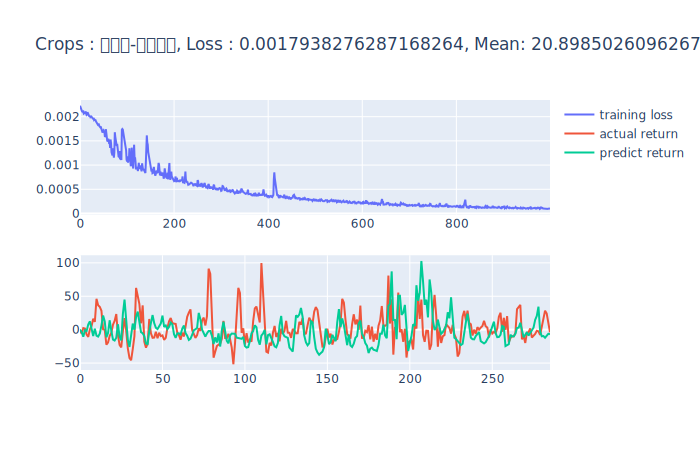

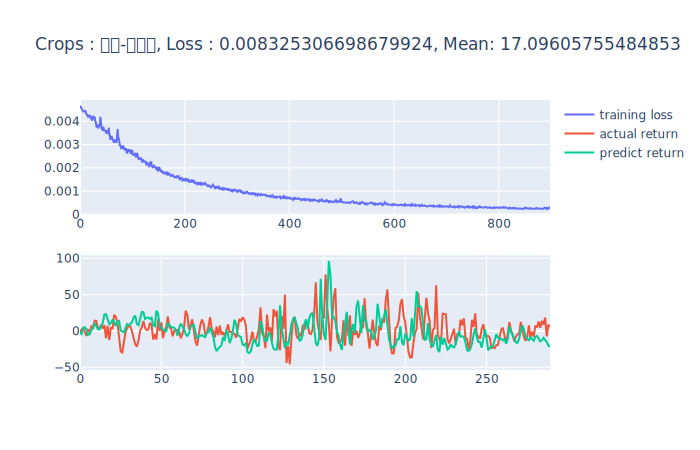

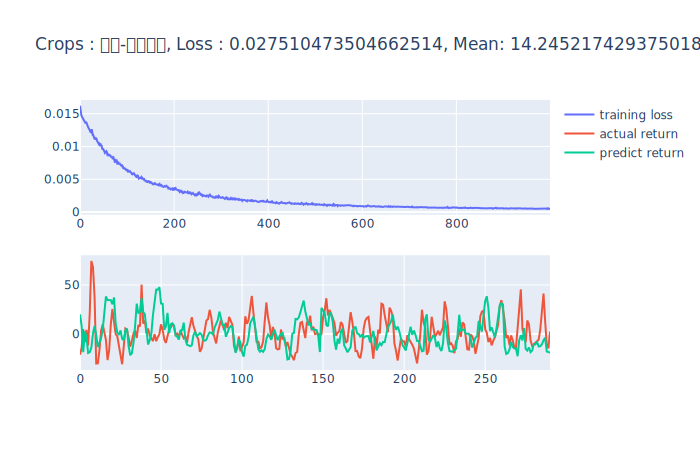

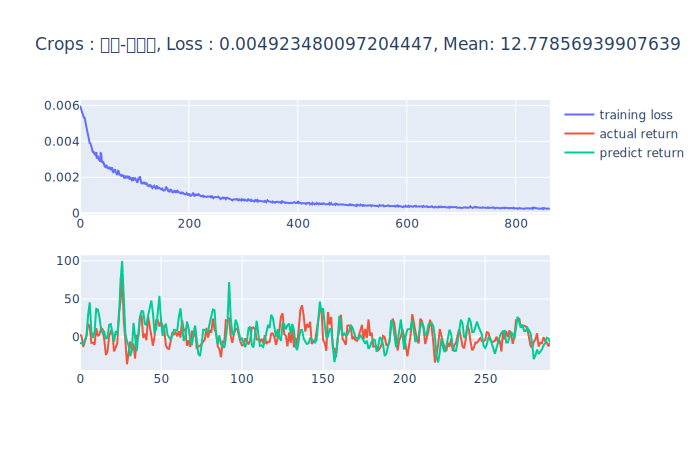

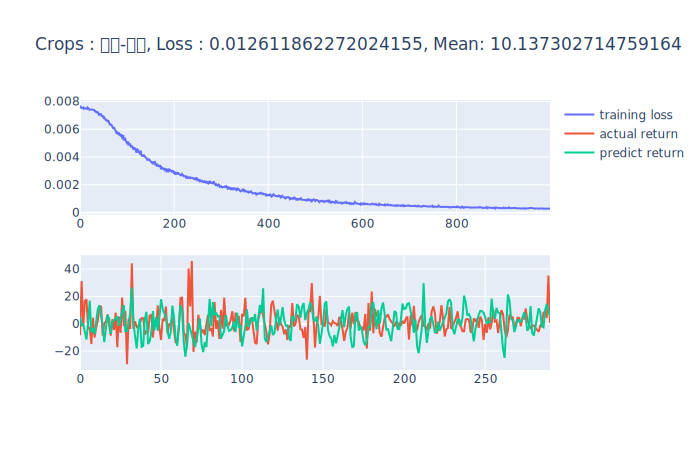

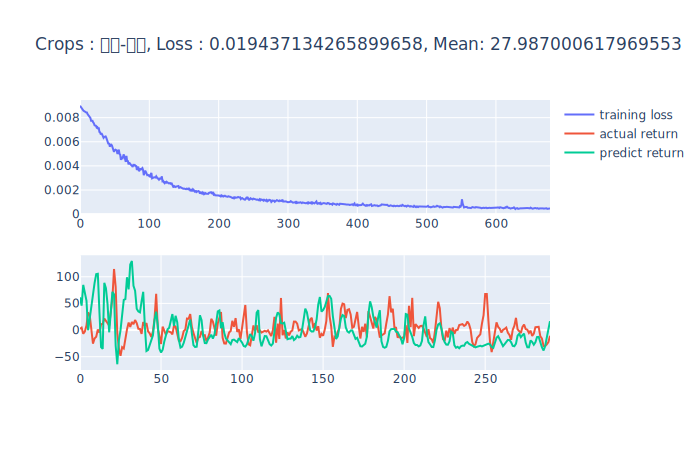

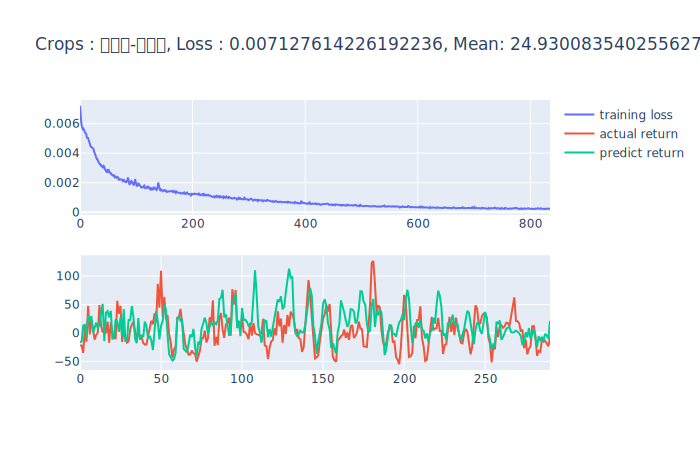

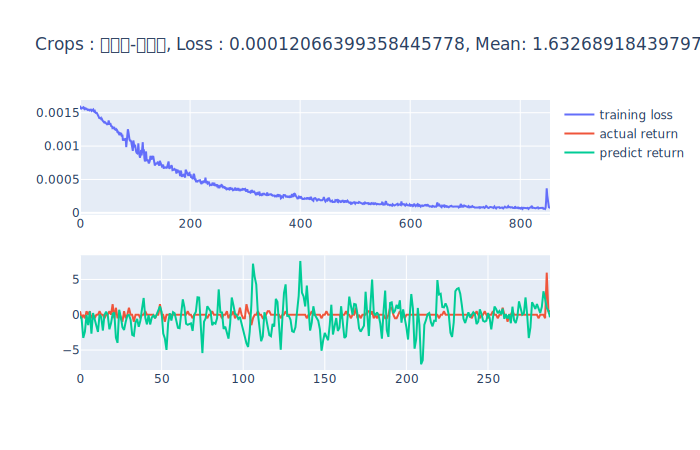

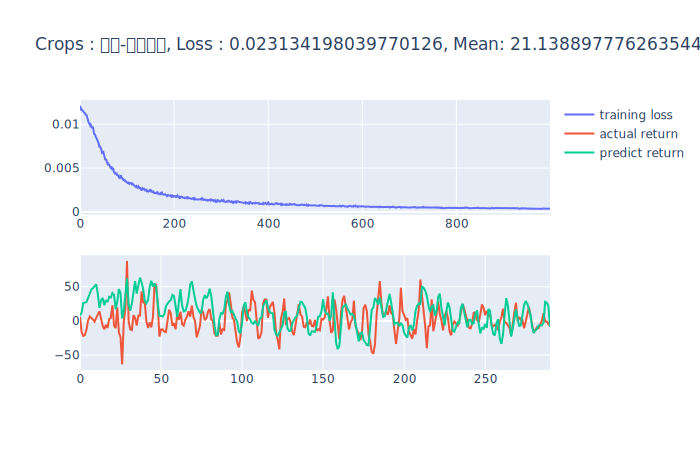

In [5]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    train(
        df.drop(columns=["DateTime", "Year", "Day", "1_day_return", "5_day_return"]),
        crops,
        split_boundary,
        "3_day_return",
    )

## Predict with feature selection
### select top 10 features of each input ( total 7 days input ) and np.unique

In [4]:
import shap

shap.initjs()

def get_important_feature(df, split_boundary, predict_target="3_day_return"):
    norm_df = normalize(df)
    X, Y = train_(norm_df, 7, 1, predict_target)
    train_x, test_x, train_y, test_y = get_train_test(X, Y, split_boundary)

    model = get_model(train_x)
    explainer = shap.GradientExplainer(model, train_x)
    shap_values = explainer.shap_values(test_x)

    feature_index_arr = []

    for i in range(7):
        feature_index_arr.append(
            np.flip(np.argsort(np.abs(shap_values[0]).mean(0))[i])[0:10]
        )
    feature_index = np.unique(feature_index_arr)
    
    # check return in df
    if 2 not in feature_index:
        feature_index = np.concatenate([[2], feature_index])

    return df.iloc[:, feature_index]


### 1 day return

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


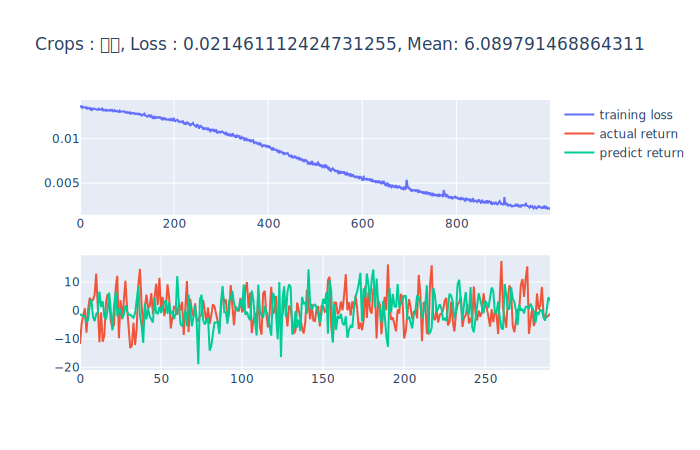

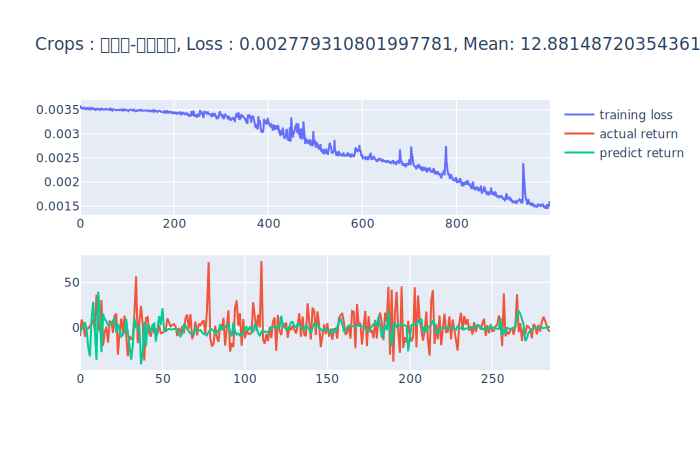

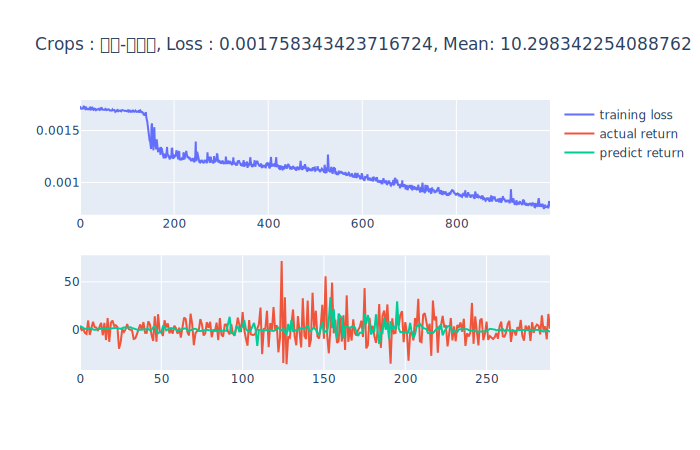

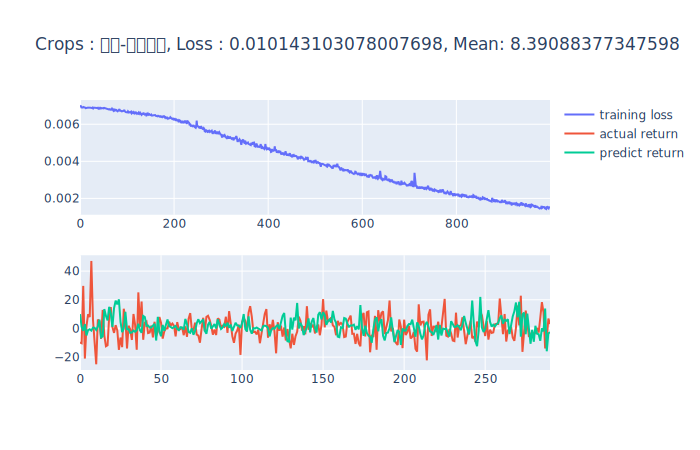

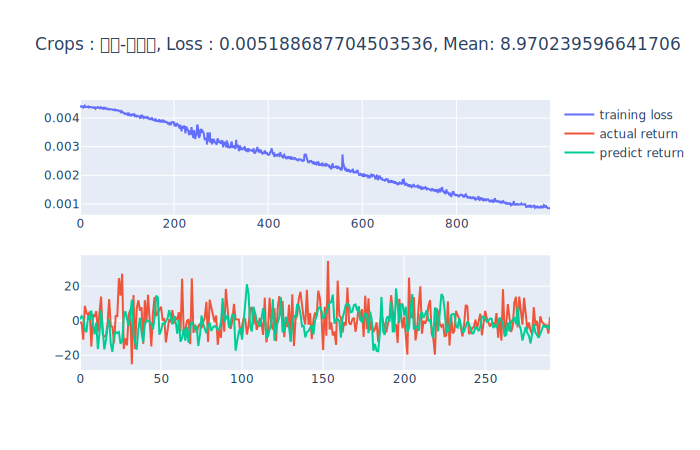

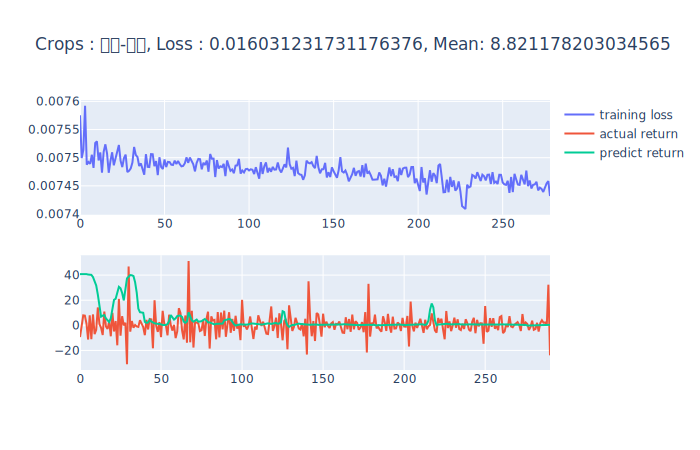

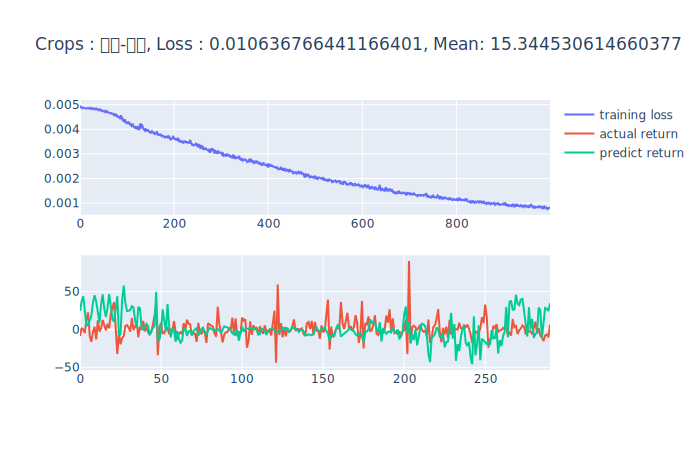

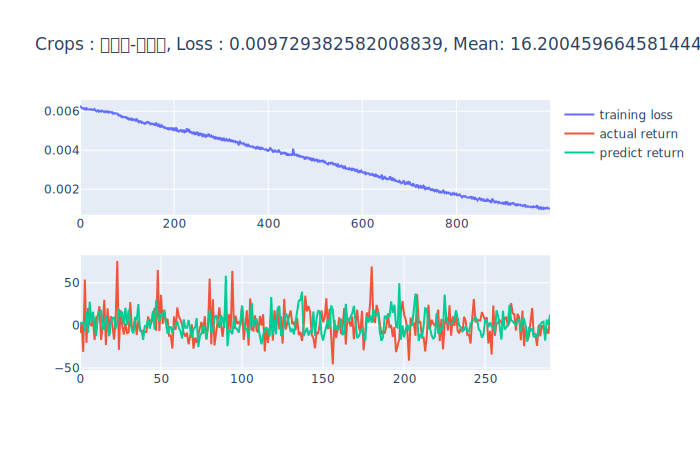

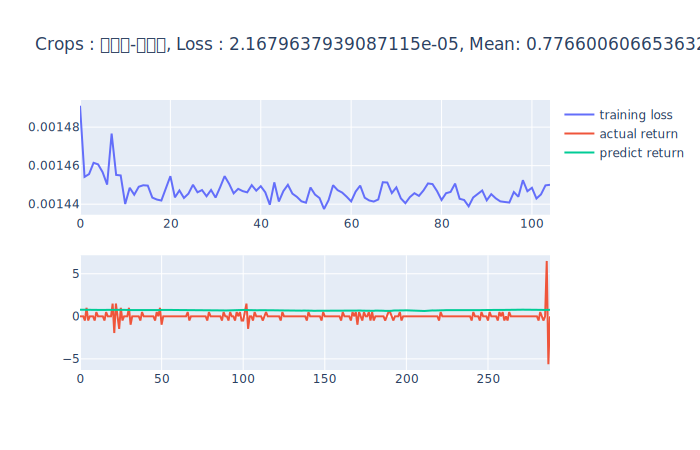

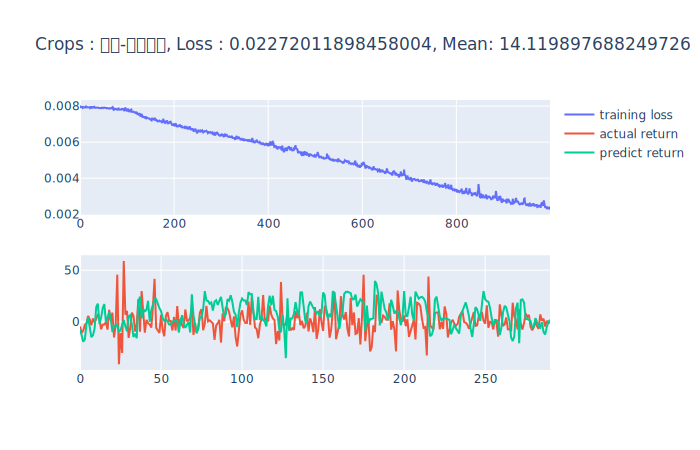

In [5]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    df = df.drop(columns=["DateTime", "Year", "Day", "3_day_return", "5_day_return"])
    df = get_important_feature(df, split_boundary, "1_day_return")
    train(df, crops, split_boundary, "1_day_return")

### 3 days return

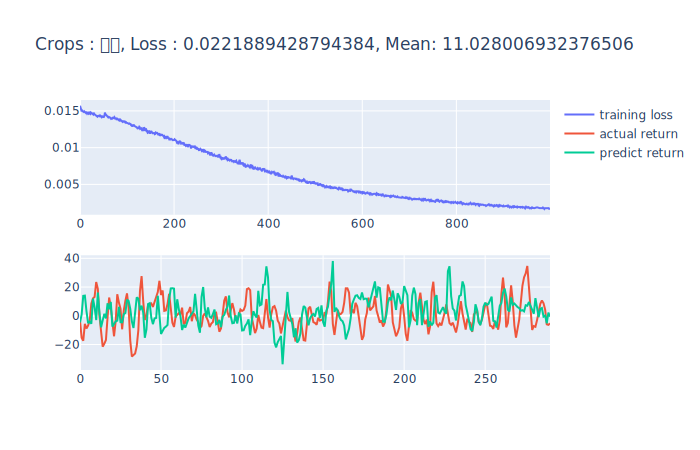

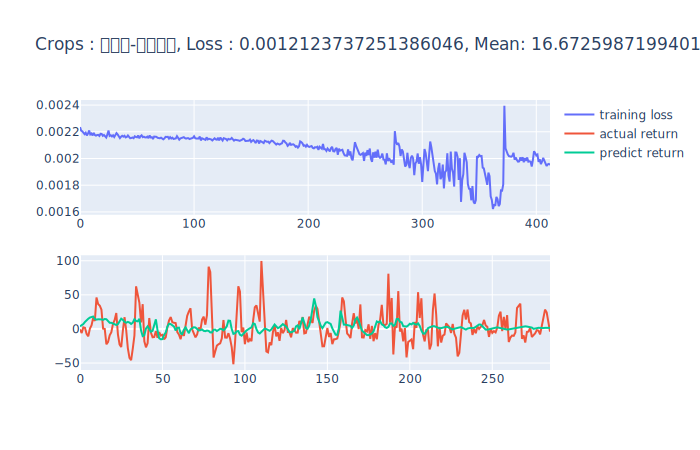

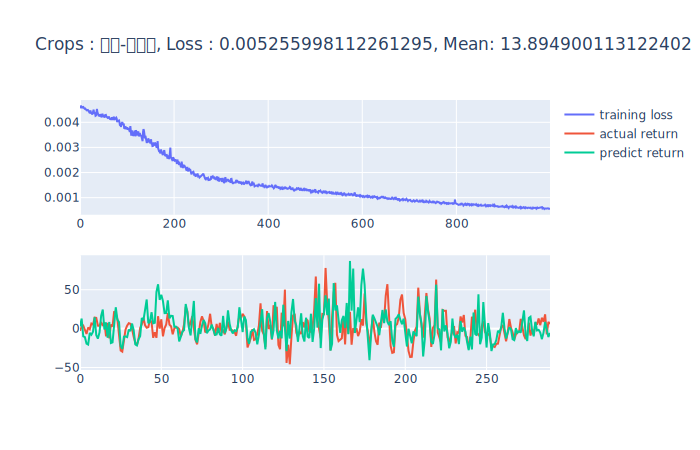

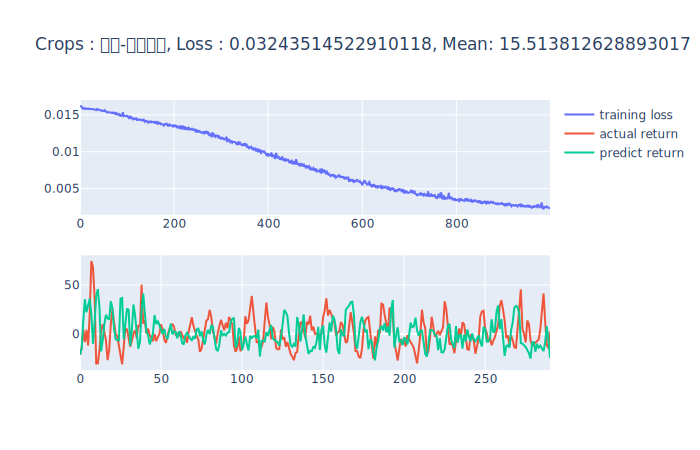

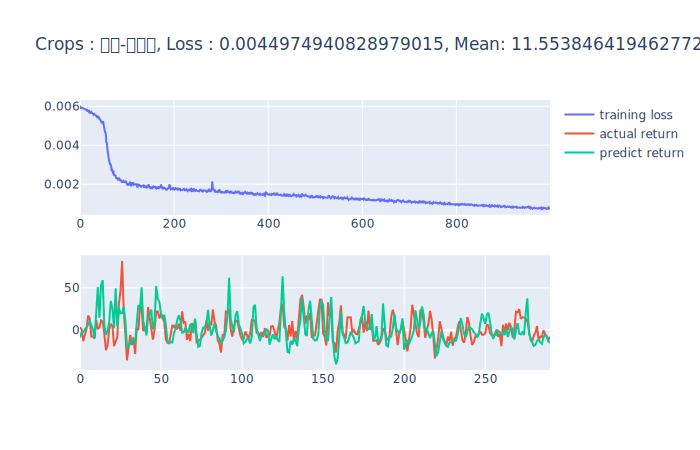

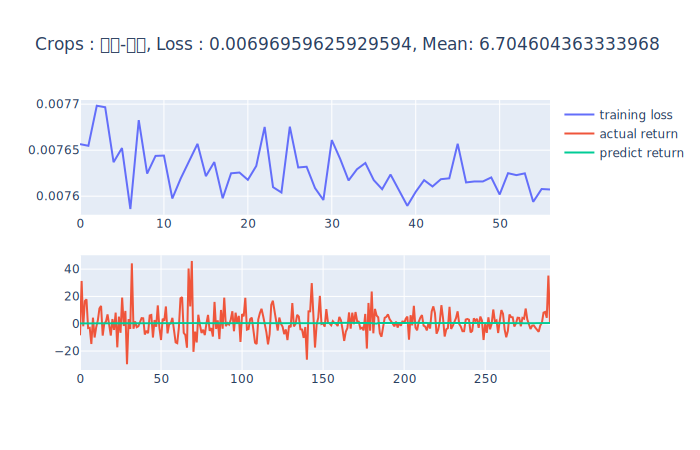

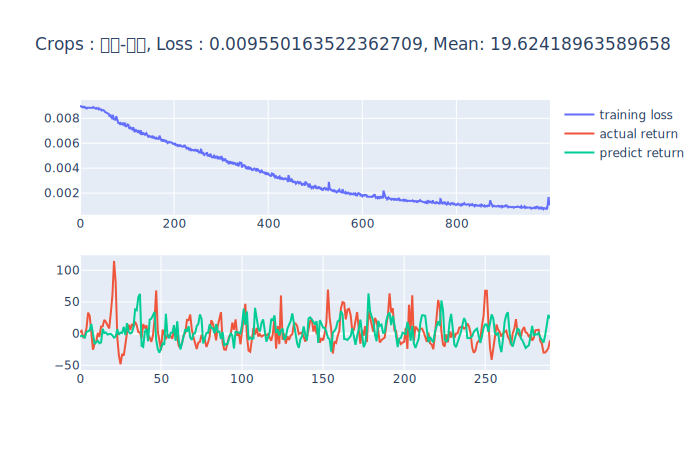

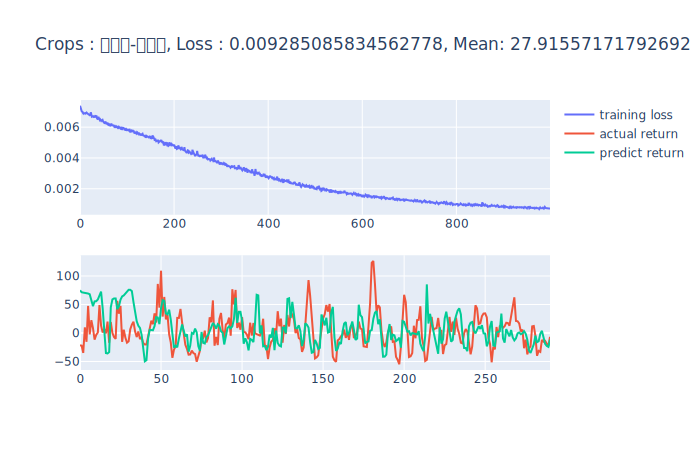

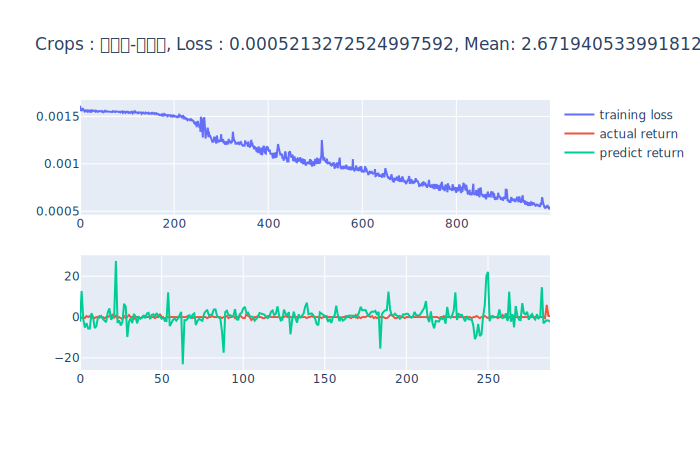

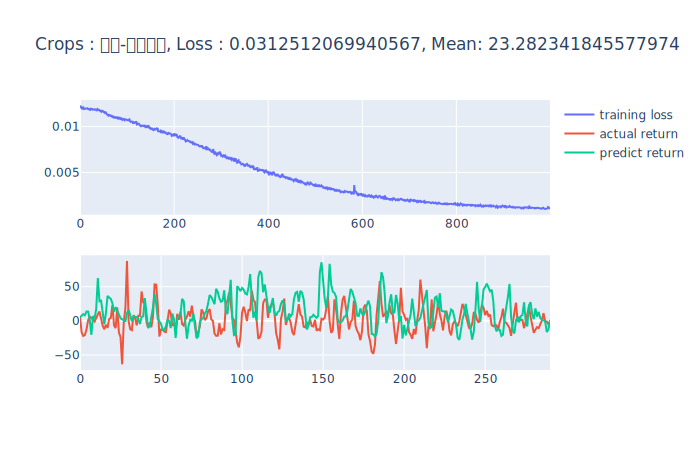

In [6]:
for crops in crops_arr:
    df = pd.read_csv("../data/{}.csv".format(crops))
    split_boundary = df.loc[df["DateTime"] == "2019-01-01"].index[0]
    df = df.drop(columns=["DateTime", "Year", "Day", "1_day_return", "5_day_return"])
    df = get_important_feature(df, split_boundary, "3_day_return")
    train(df, crops, split_boundary, "3_day_return")